# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-25000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_residual_stride_25000'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        return x

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size

        # Encoder
        self.encoder = nn.Sequential(
            ResidualBlock(3, 32, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 64, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 128, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            ResidualBlock(128, 128),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 32),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import calc_and_plot_metrics, fit_nearest_neighbor, train_model_steps, plot_model, count_parameters, save_to_file, load_from_file

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    fit_nearest_neighbor(model)
    calc_and_plot_metrics(model, testset)
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 832615


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.322
Shape Accuracy: 0.74
Combined Accuracy: 0.232


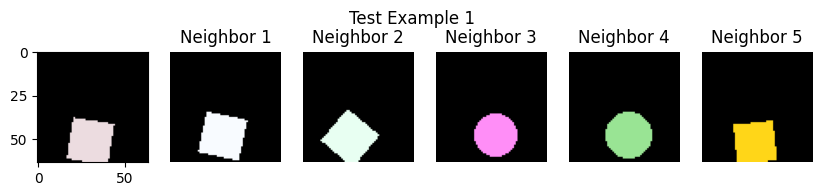

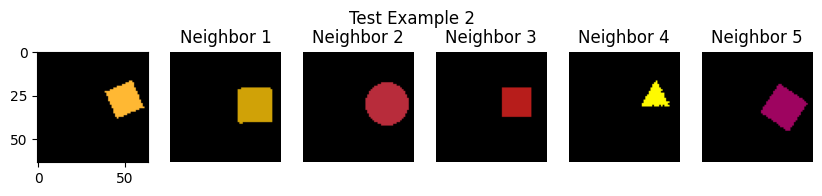

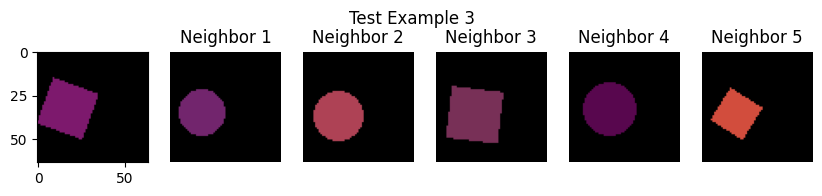

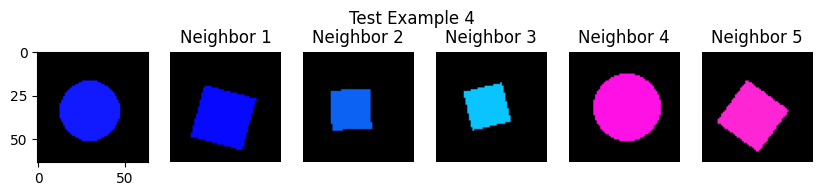

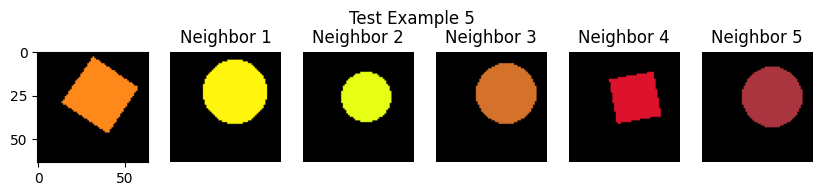

Silhouette Score: -0.2124873697757721
Cluster Purity: 0.196
Normalized Mutual Information (NMI): 0.25905581487591106


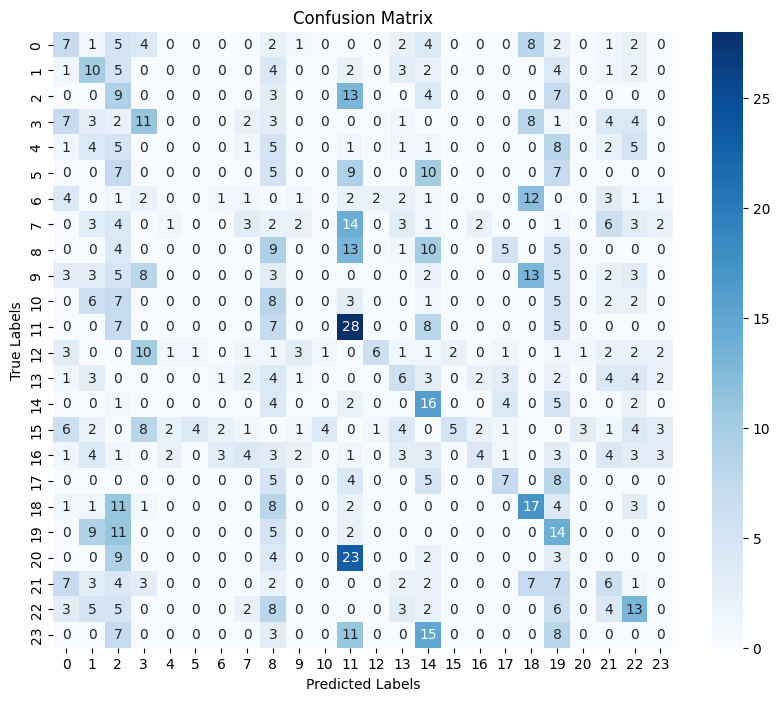

Silhouette Score: -0.16087768971920013
Cluster Purity: 0.206
Normalized Mutual Information (NMI): 0.06933419508262363


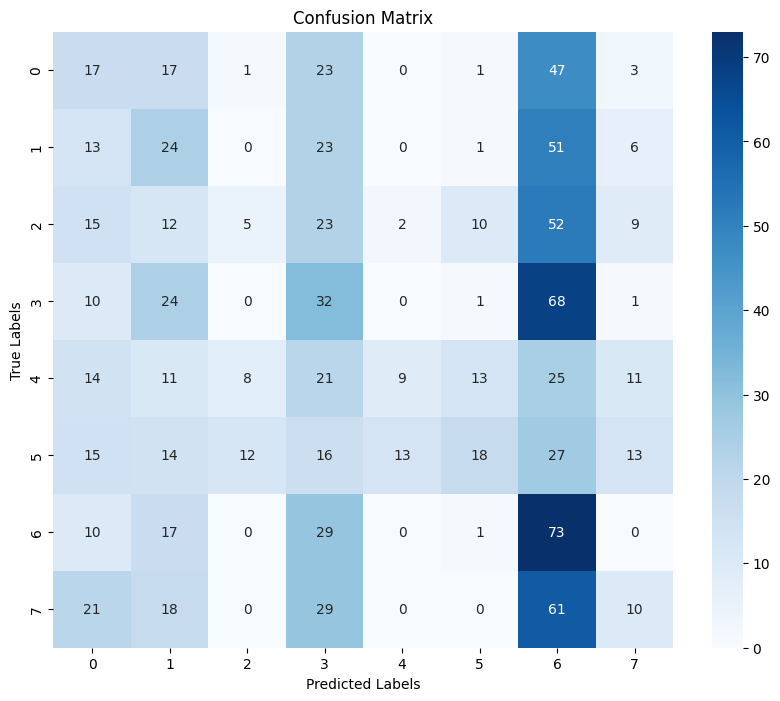

Silhouette Score: 0.00531679717823863
Cluster Purity: 0.508
Normalized Mutual Information (NMI): 0.1670400403776459


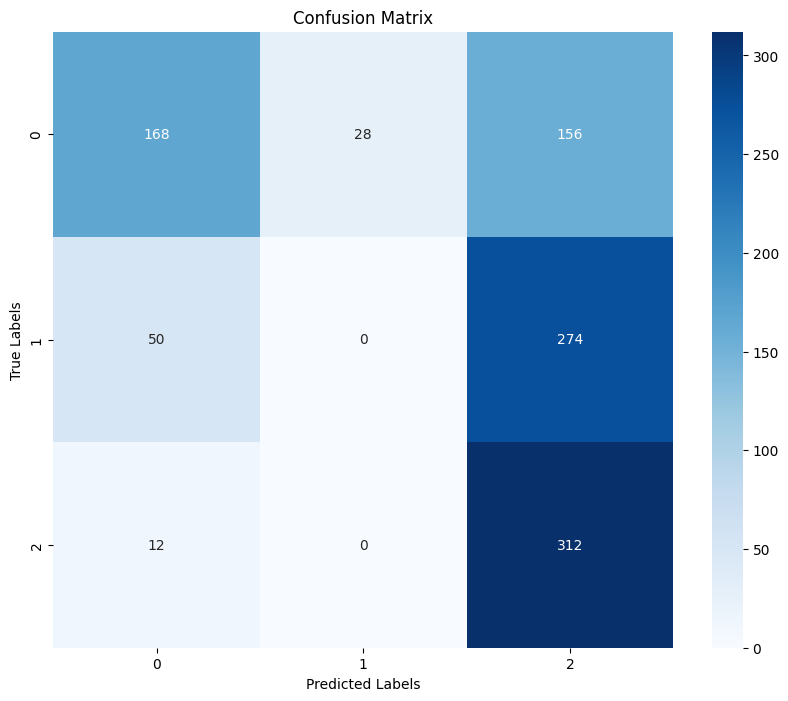

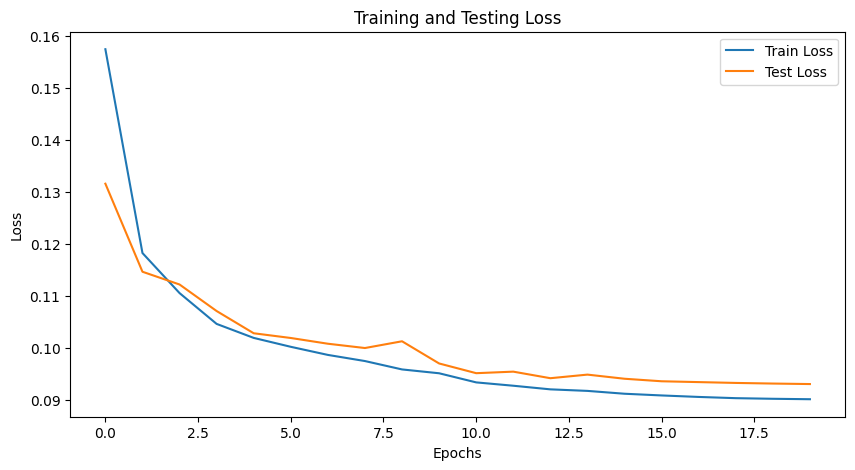

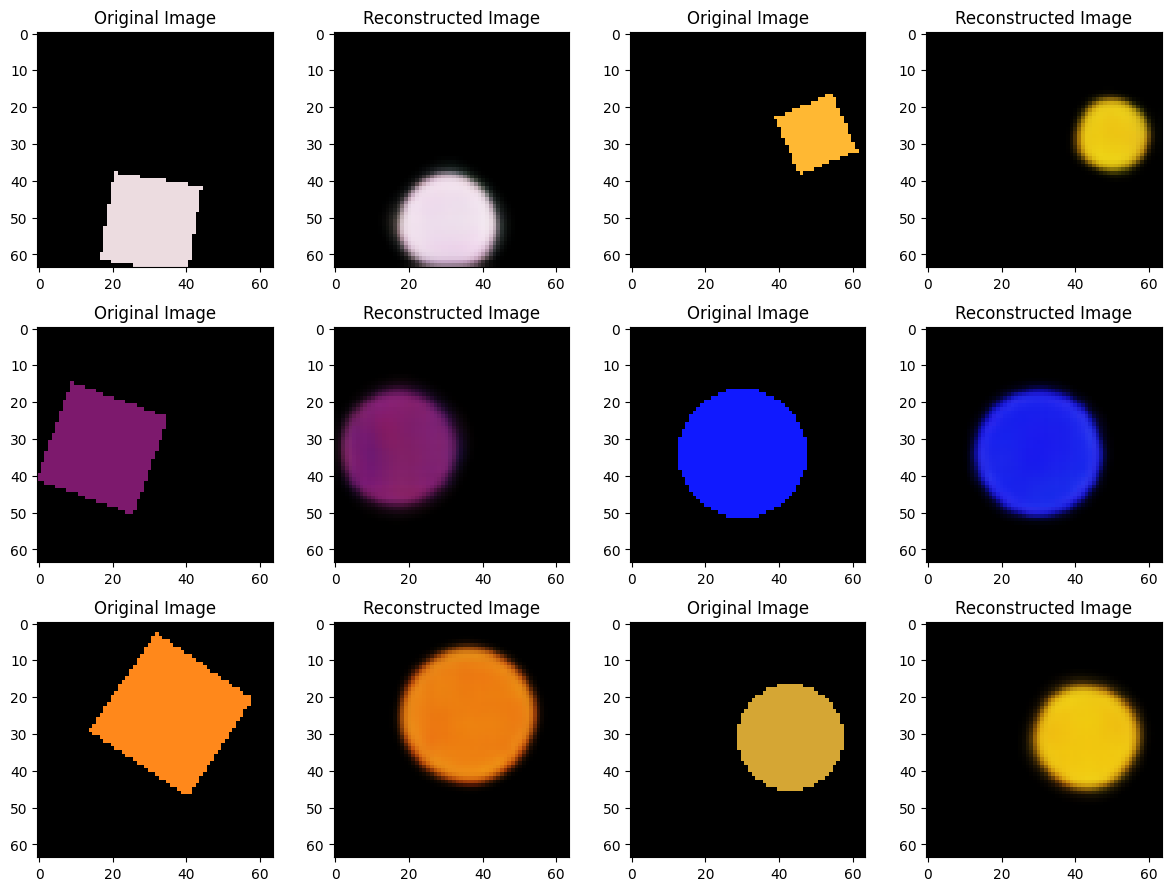

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 898155


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.263
Shape Accuracy: 0.866
Combined Accuracy: 0.224


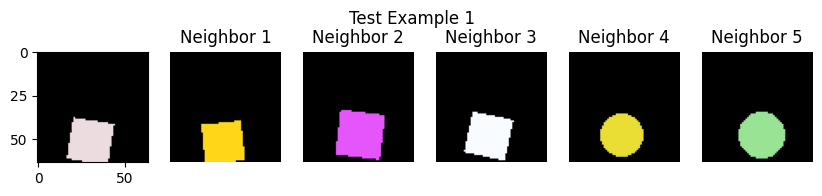

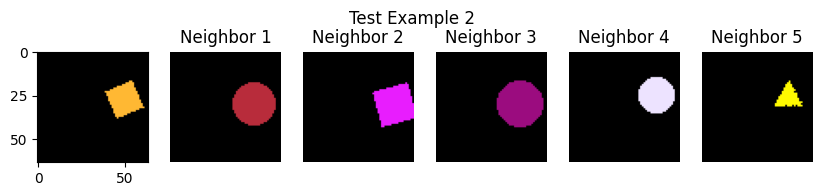

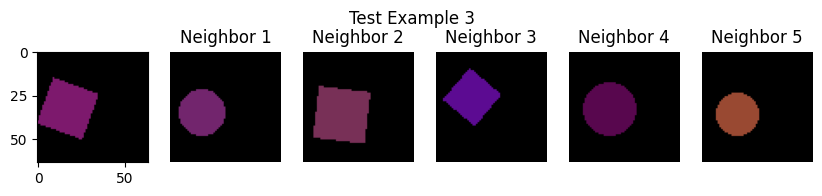

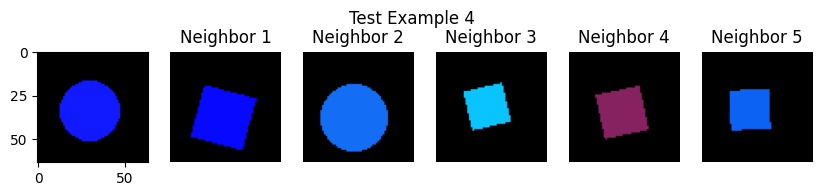

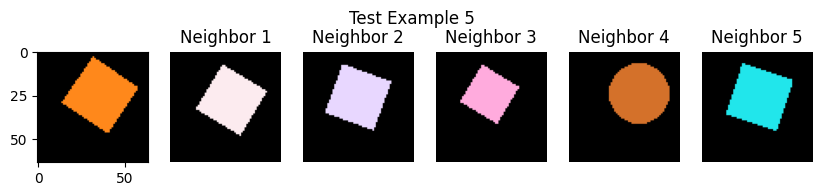

Silhouette Score: -0.14482153952121735
Cluster Purity: 0.191
Normalized Mutual Information (NMI): 0.2698416843641569


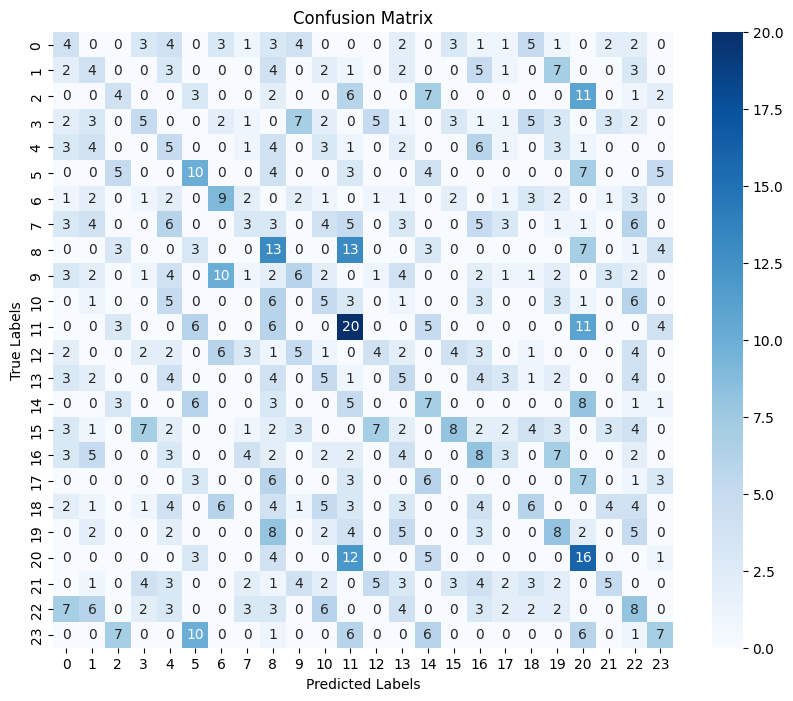

Silhouette Score: -0.11765938252210617
Cluster Purity: 0.179
Normalized Mutual Information (NMI): 0.0231878412856875


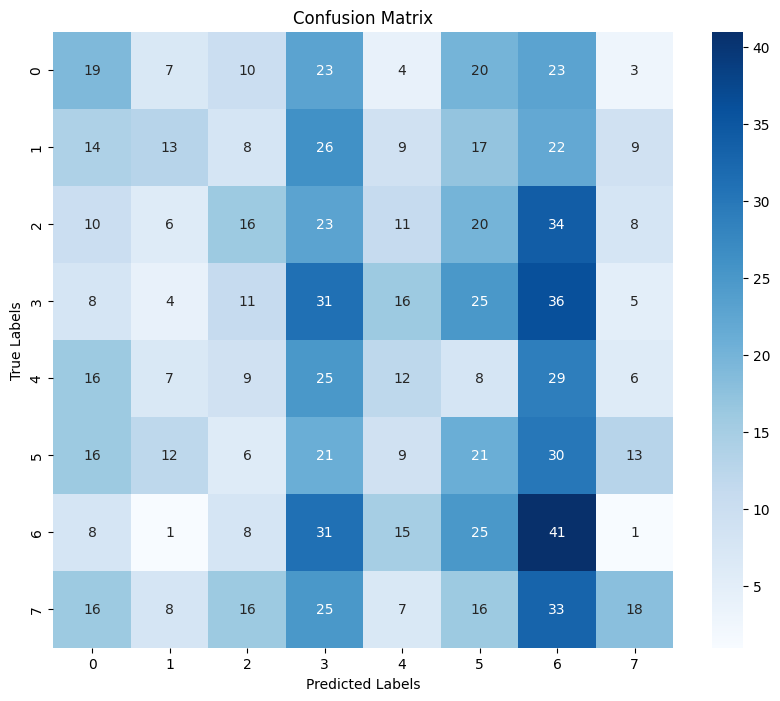

Silhouette Score: 0.03211122006177902
Cluster Purity: 0.519
Normalized Mutual Information (NMI): 0.20013942683941505


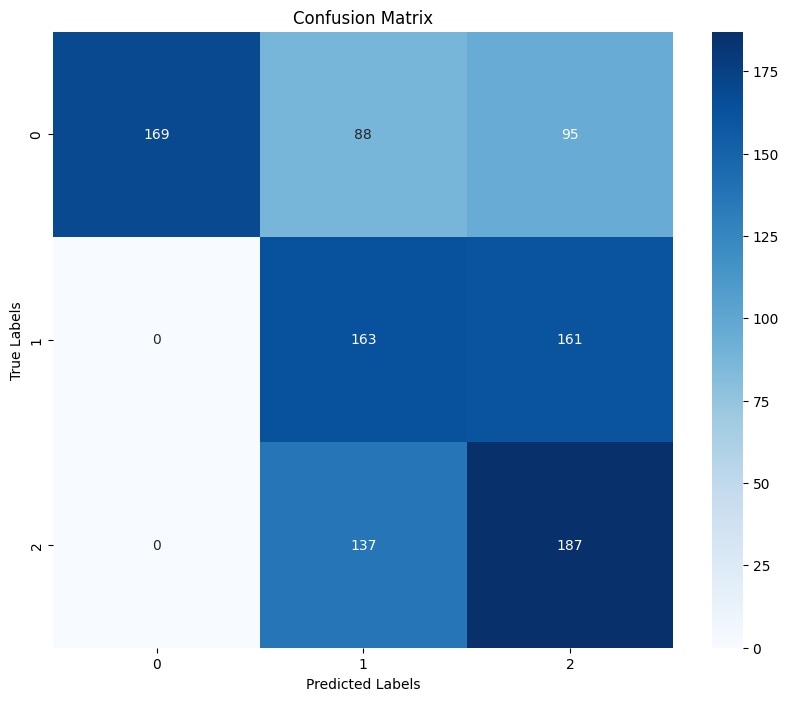

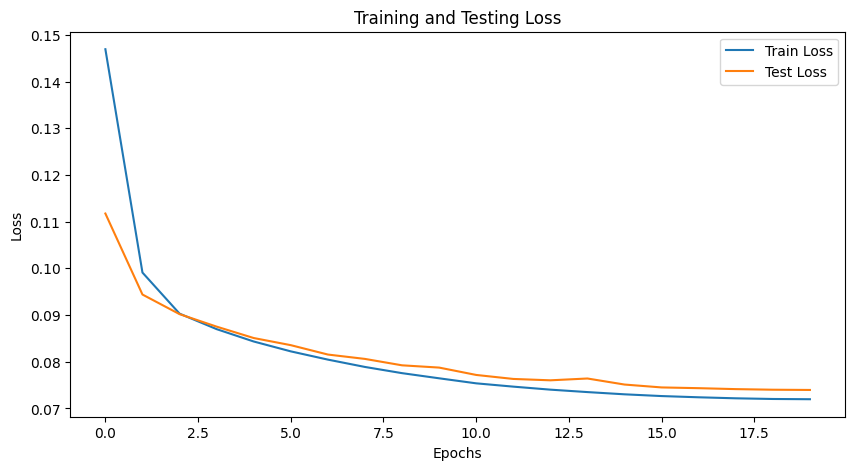

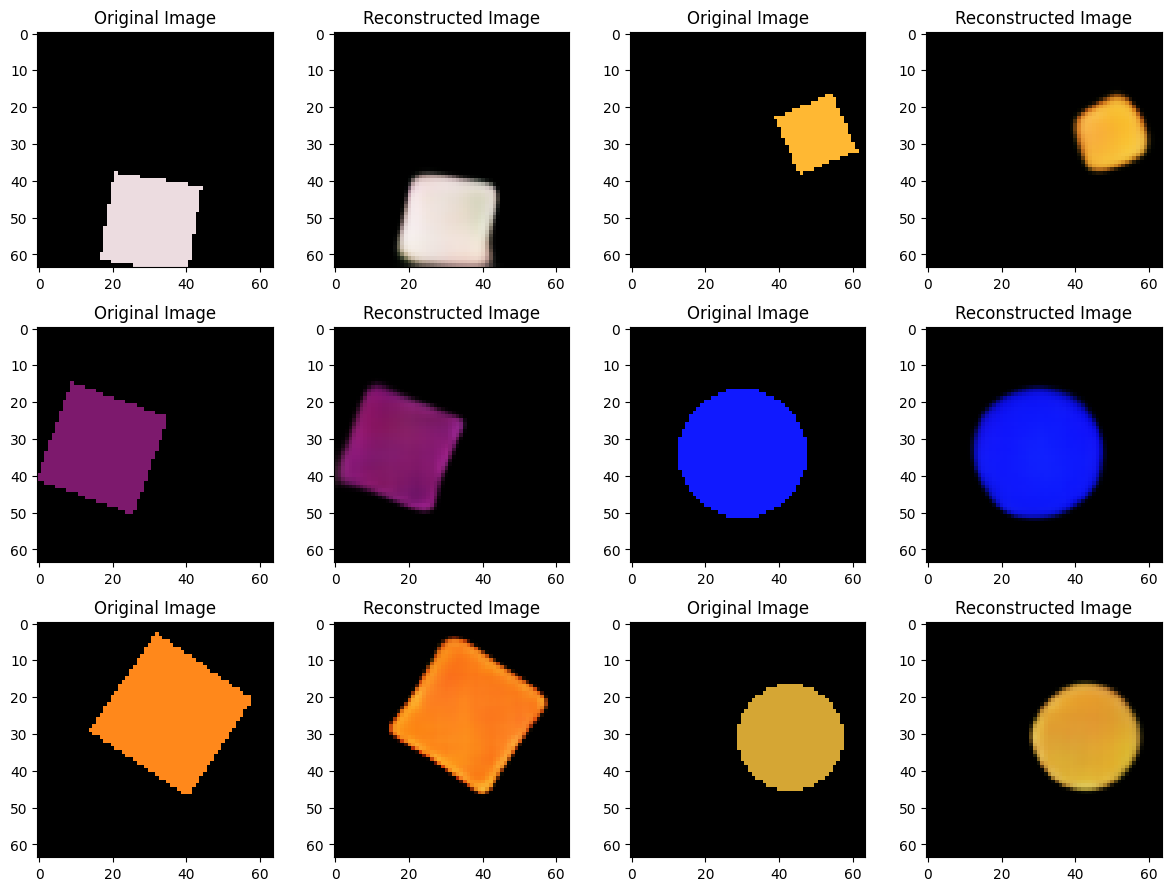

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 1029235


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.262
Shape Accuracy: 0.845
Combined Accuracy: 0.217


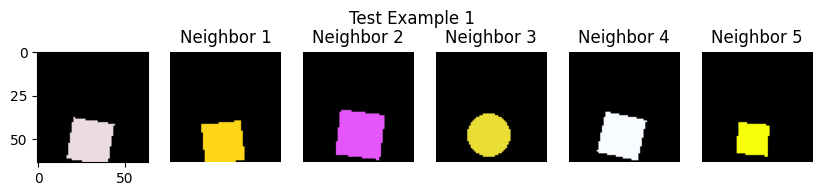

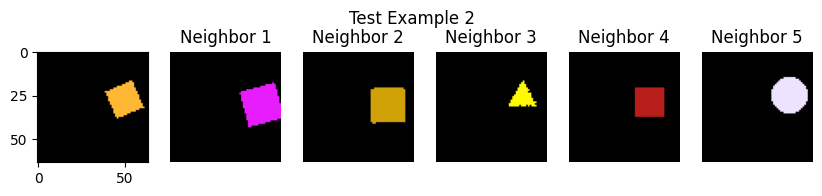

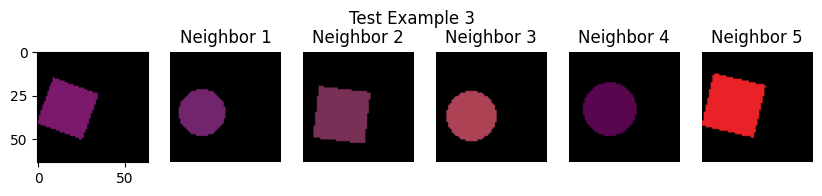

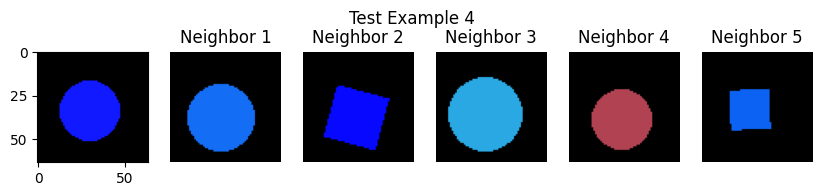

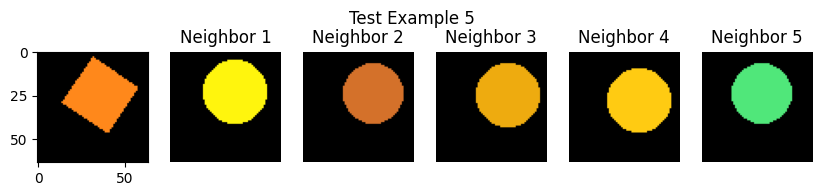

Silhouette Score: -0.15341782569885254
Cluster Purity: 0.194
Normalized Mutual Information (NMI): 0.2516101128893423


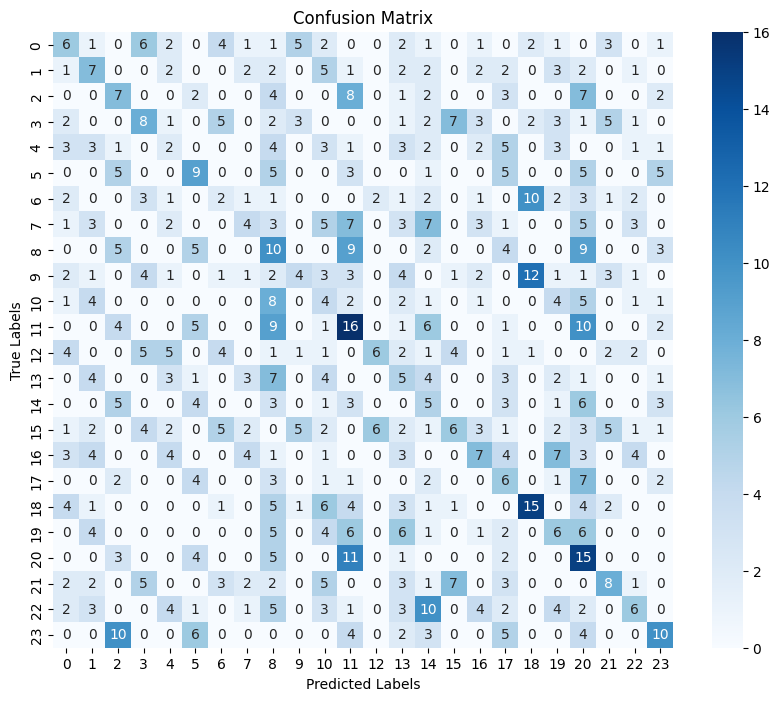

Silhouette Score: -0.13039951026439667
Cluster Purity: 0.187
Normalized Mutual Information (NMI): 0.022491864849646284


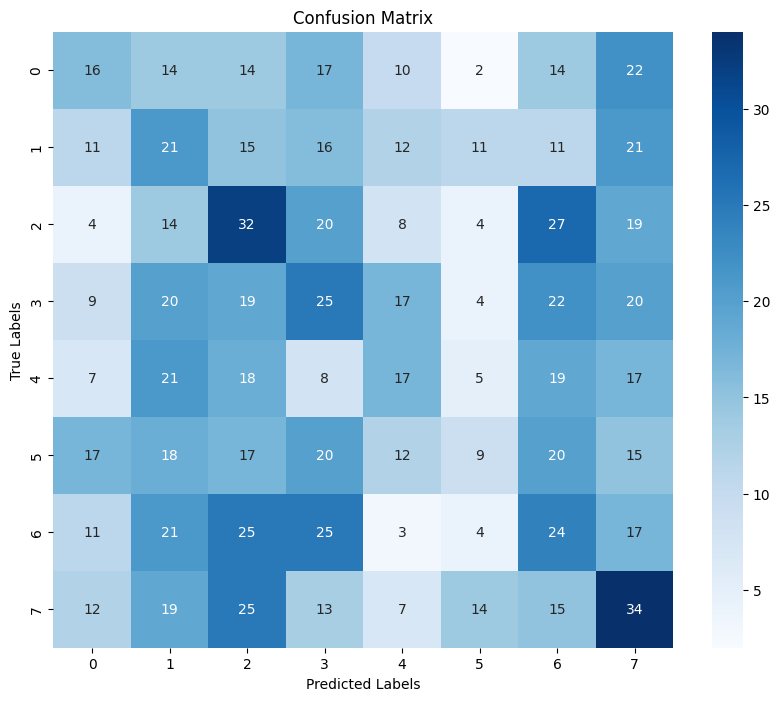

Silhouette Score: 0.017613226547837257
Cluster Purity: 0.523
Normalized Mutual Information (NMI): 0.19289254211329185


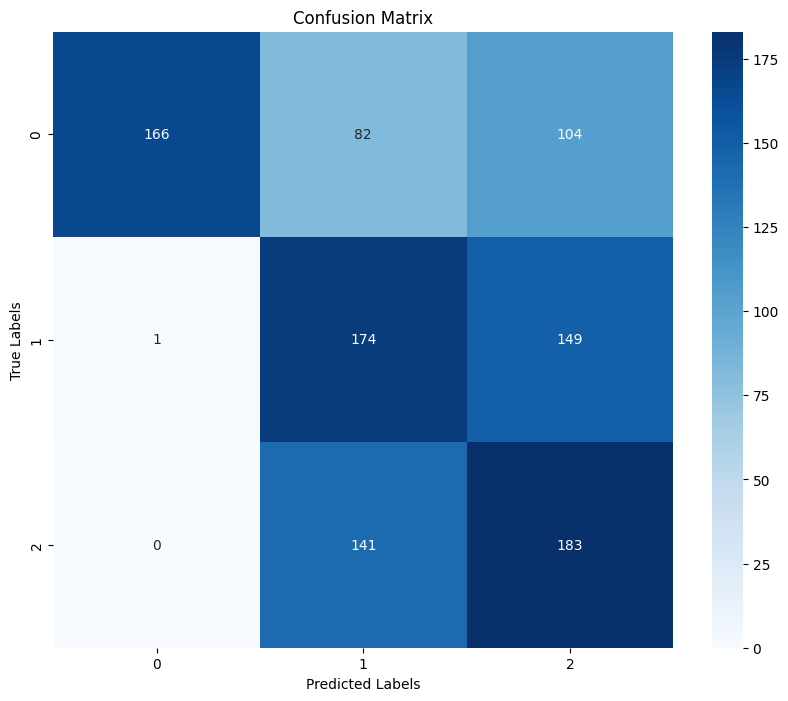

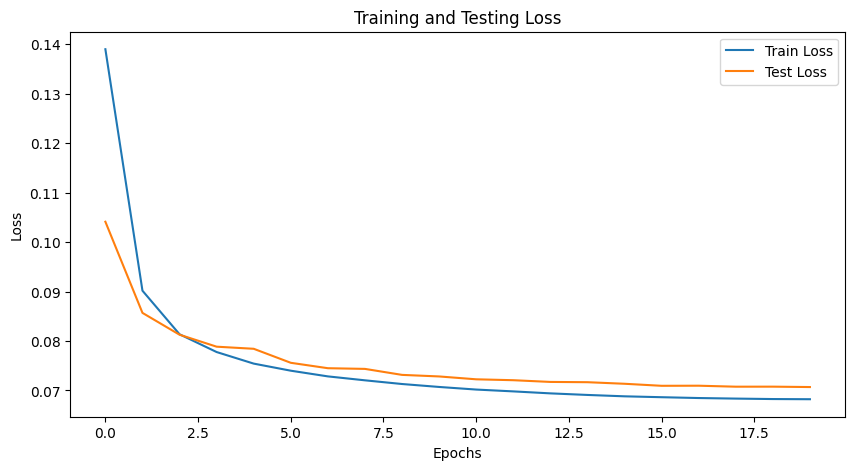

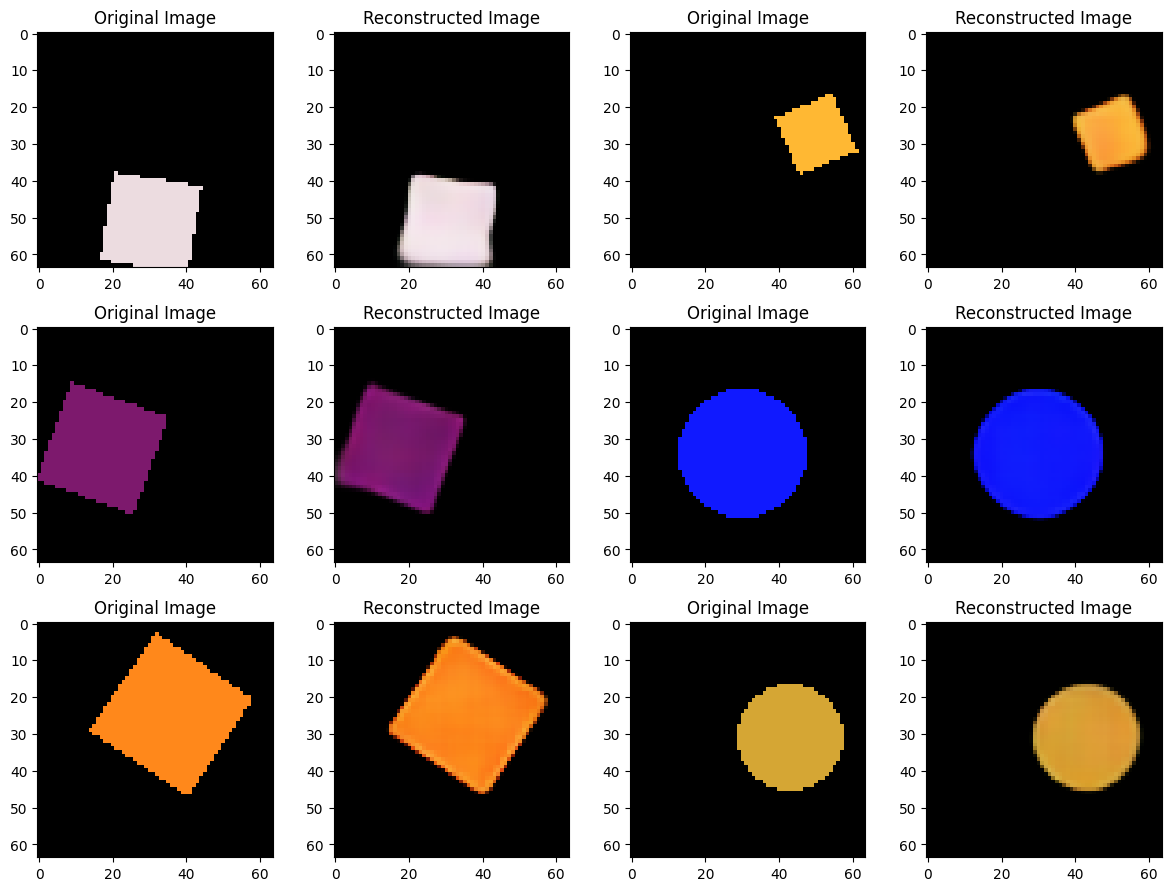

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 1291395


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.26
Shape Accuracy: 0.847
Combined Accuracy: 0.213


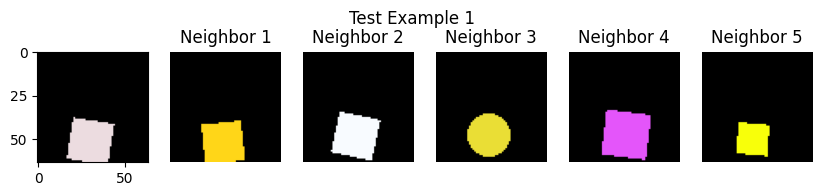

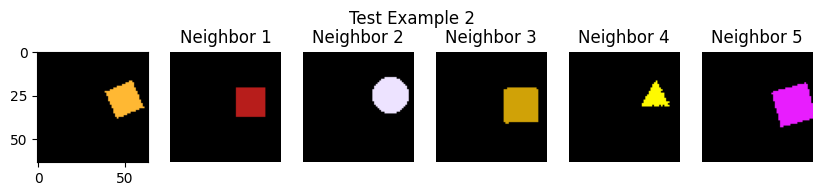

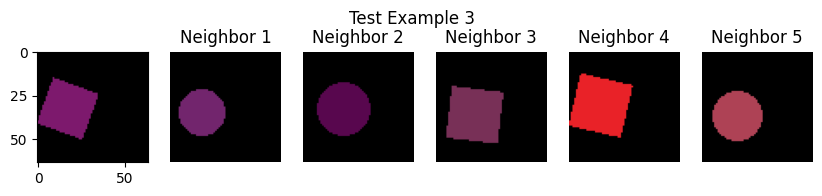

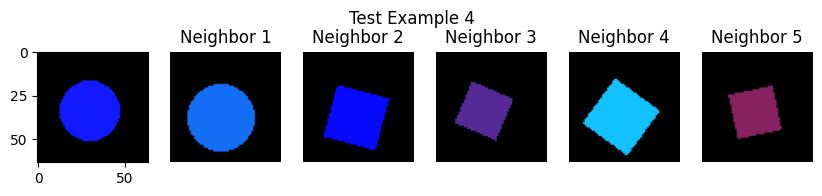

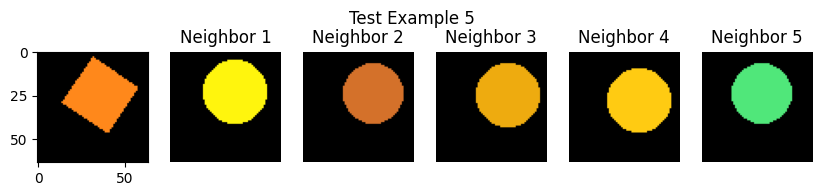

Silhouette Score: -0.14976517856121063
Cluster Purity: 0.183
Normalized Mutual Information (NMI): 0.2354586243901442


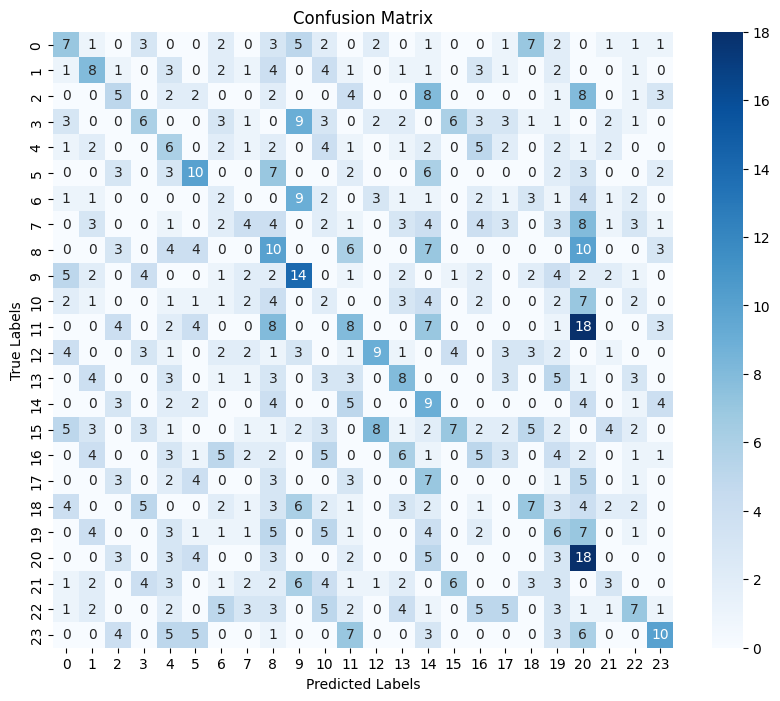

Silhouette Score: -0.1207503080368042
Cluster Purity: 0.181
Normalized Mutual Information (NMI): 0.017065403519599995


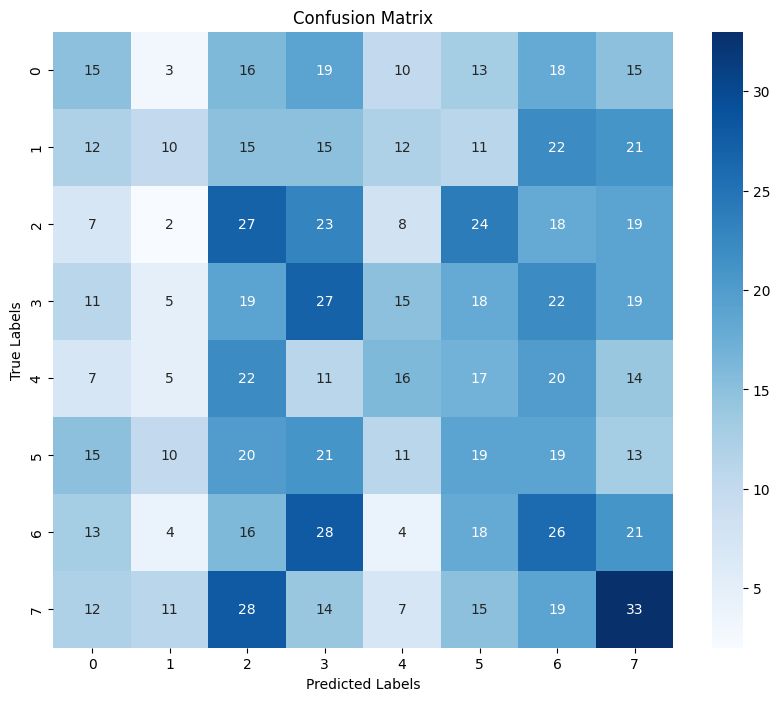

Silhouette Score: 0.012364372611045837
Cluster Purity: 0.518
Normalized Mutual Information (NMI): 0.19680505477550983


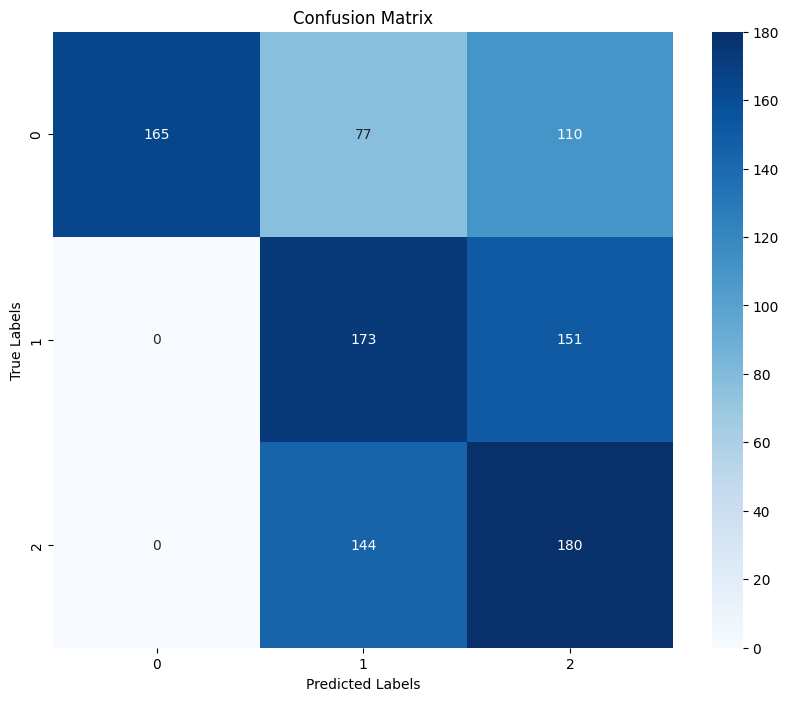

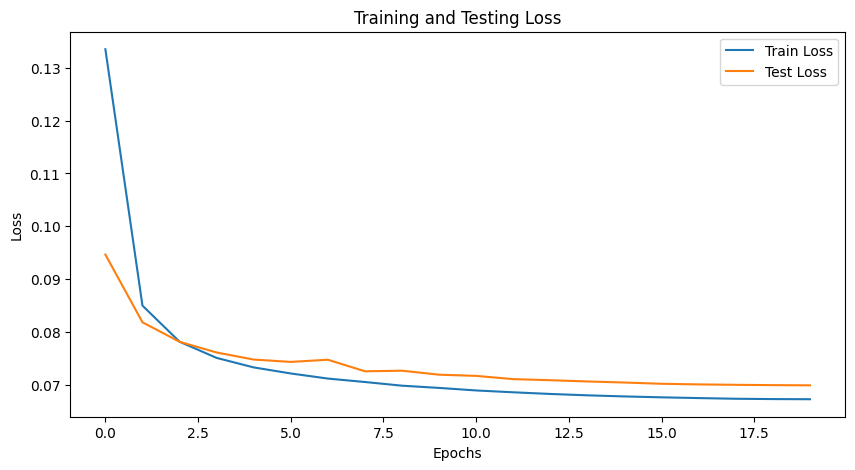

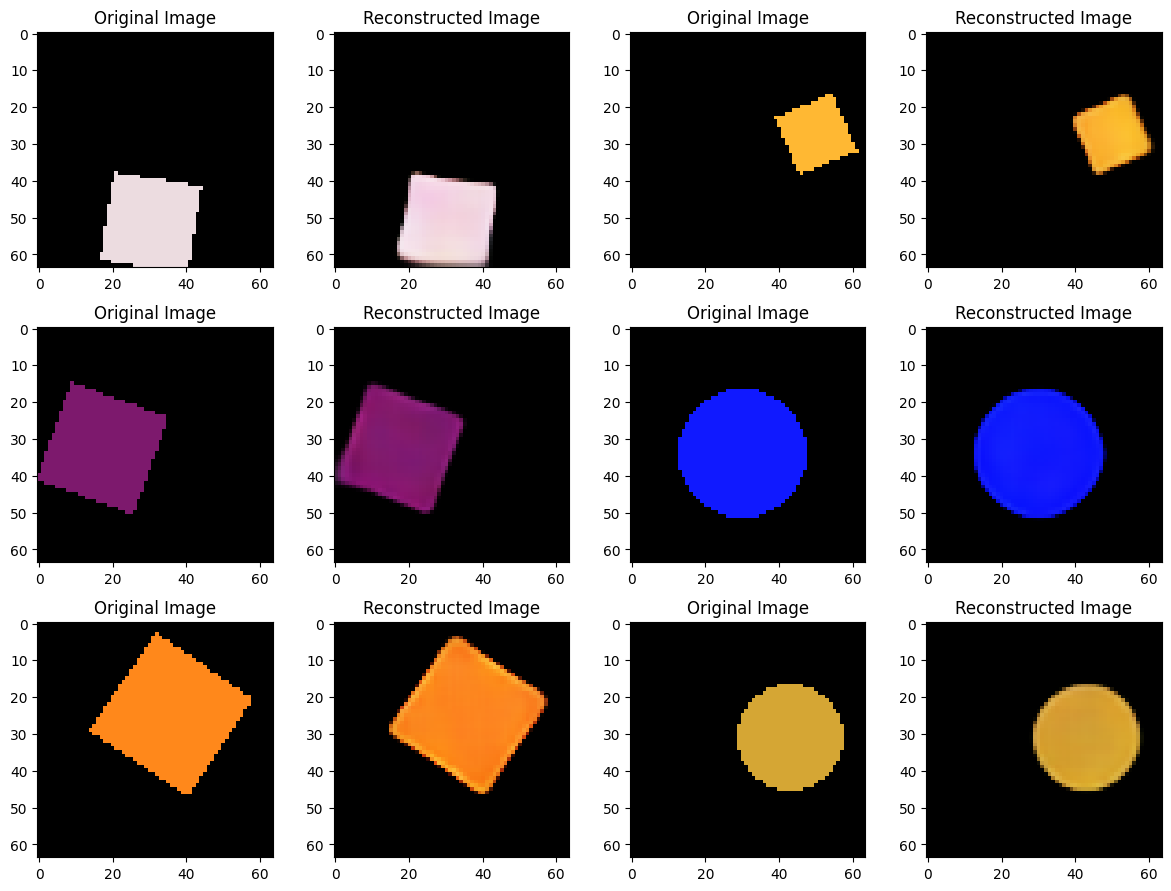

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 1815715


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.247
Shape Accuracy: 0.824
Combined Accuracy: 0.195


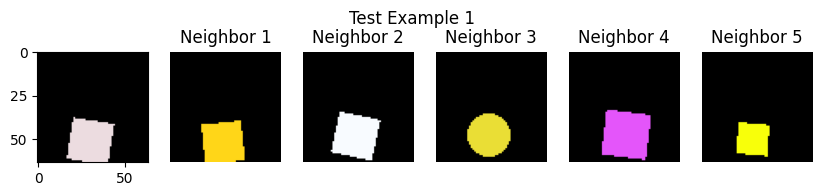

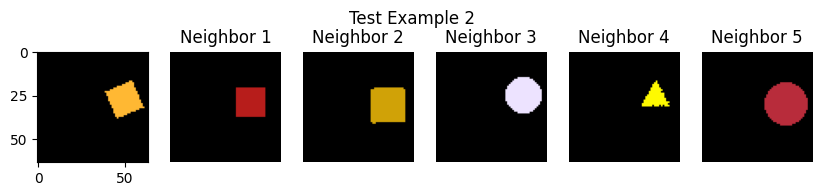

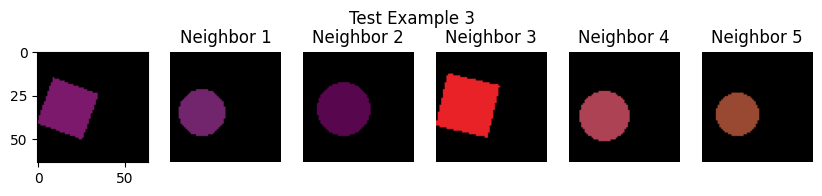

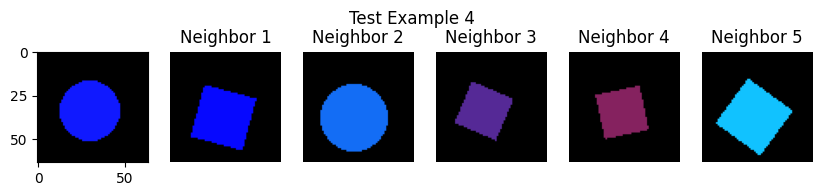

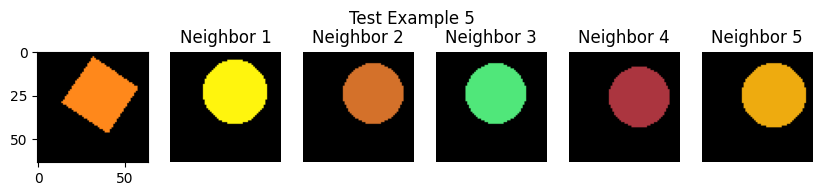

Silhouette Score: -0.15762396156787872
Cluster Purity: 0.189
Normalized Mutual Information (NMI): 0.24733392665638934


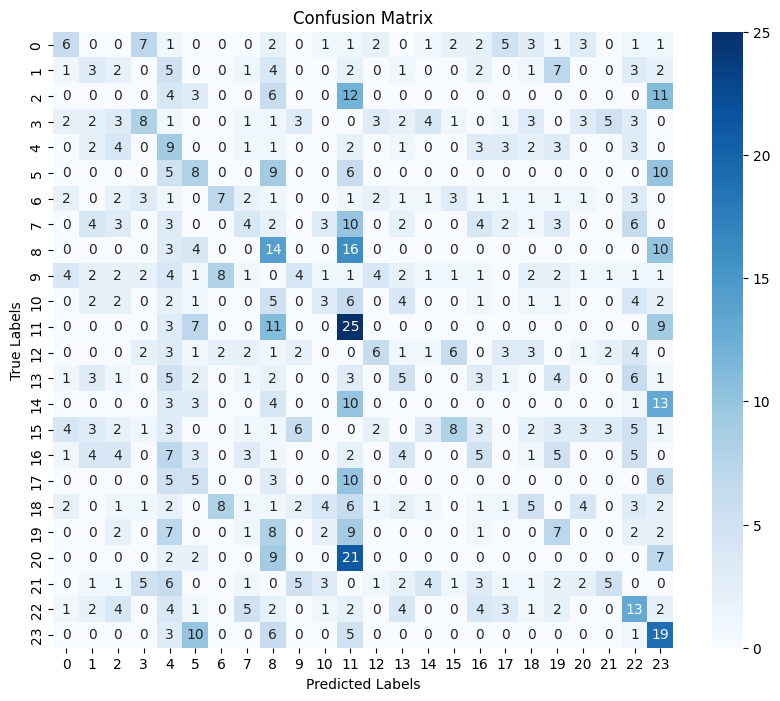

Silhouette Score: -0.12144436687231064
Cluster Purity: 0.181
Normalized Mutual Information (NMI): 0.020650048407819956


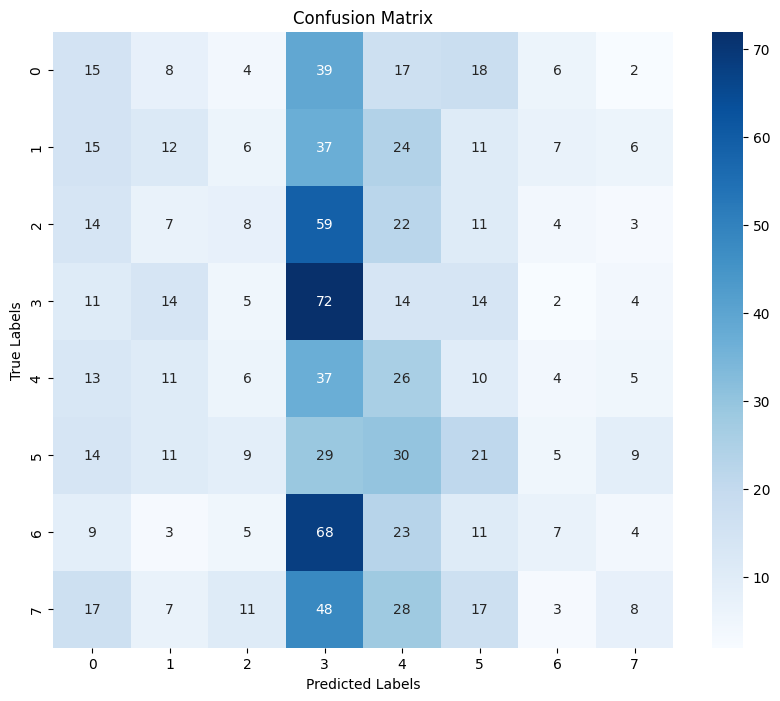

Silhouette Score: 0.0027239914052188396
Cluster Purity: 0.556
Normalized Mutual Information (NMI): 0.26717705197666713


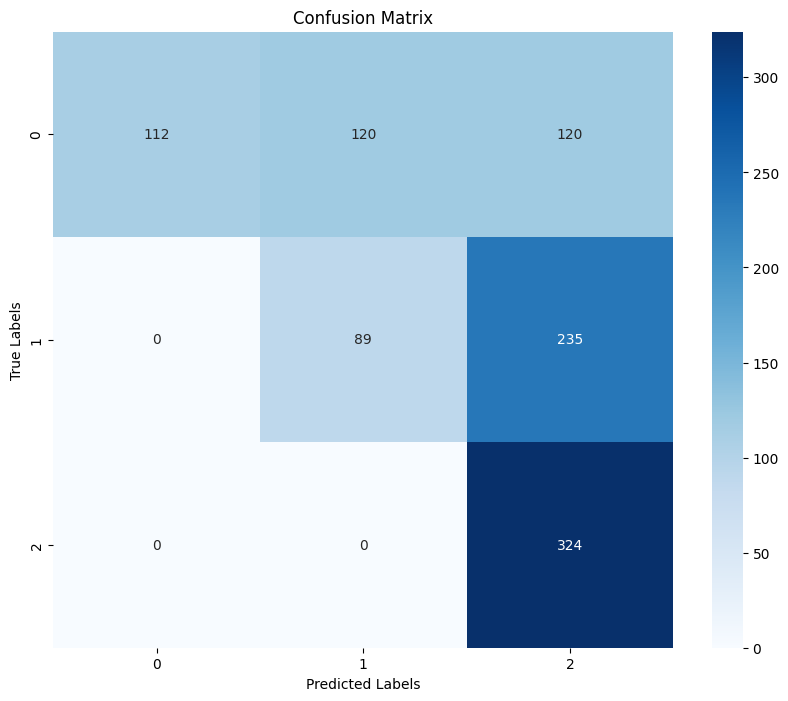

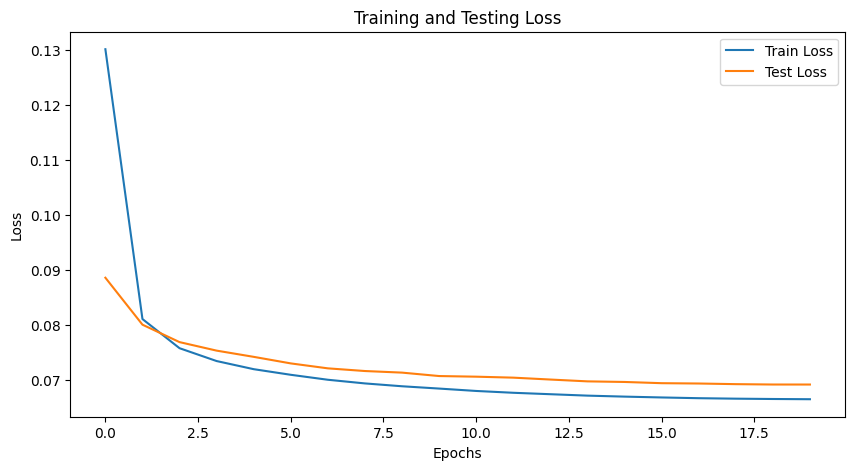

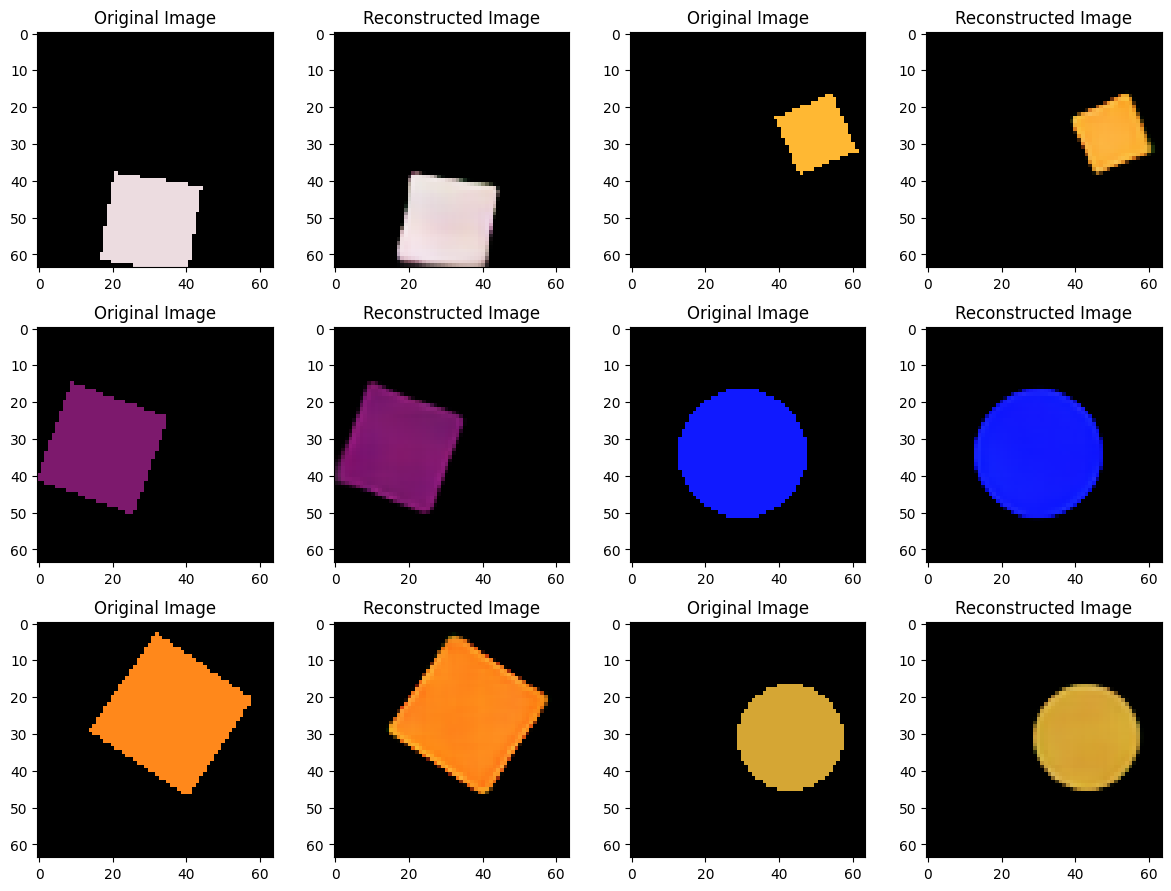

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)